# Demo: making boundary conditions and visualising them

Take a dataset and create boundary conditions for your specified grid.

In [32]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import sys
sys.path.append('/home/users/birgal/')
from nemo_python.ics_obcs import create_bcs
from nemo_python.utils import convert_to_teos10

#### Load bathymetry files

In [11]:
# NEMO mesh mask and domain files
bathy_folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/'
nemo_mask    = xr.open_dataset(f'{bathy_folder}mesh_mask-20240201.nc').isel(time_counter=0)

## Create boundary conditions

In [5]:
variable='SSH'
varname ='ETAN'

source_folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/'
bathy_folder  = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/'
BC_folder     = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/B-SOSE/'

In [3]:
month = 1

file_SOSE   = f'{source_folder}{variable}_climatology_m{month:02}.nc';
output_file = f'{BC_folder}SOSE-{variable}-boundary-conditions-20240125_m{month:02}.nc'

create_bcs(varname, file_SOSE, output_file,
           source       = 'SOSE',
           source_coord = f'{source_folder}{variable}_climatology_m{month:02}.nc',
           nemo_coord   = f'{bathy_folder}domain_cfg-20240201.nc',
           nemo_mask    = f'{bathy_folder}mesh_mask-20240201.nc',
           salt_file    = f'{source_folder}SALT_climatology_m{month:02}.nc',
           folder       = f'{BC_folder}',
           fill_value   = 0,
           seaice       = False,
           bdy_lat      = -50)

## Visualise boundary conditions

In [61]:
var   = 'SALT'
month = 2
# Load boundary condition files:
bdy_cond   = xr.open_dataset(f'{BC_folder}SOSE-SALT-boundary-conditions-20240125_m{month:02}.nc').isel(time_counter=0, y=0)
# Load source dataset files:
source_var = xr.open_dataset(f'{source_folder}SALT_climatology_m{month:02}.nc')

In [62]:
# Subset dataset:  
bdy_lat     = -50
source_var  = source_var.rename({'XC':'lon', 'YC':'lat', 'Depth':'depth'})
source_var  = source_var.sel(lat=slice(bdy_lat-1, bdy_lat+1))
# Find strip of points nearest bdy_lat
bdy_ind     = np.argmin(np.abs(source_var.lat.values - bdy_lat))
source_varp = xr.where(source_var[var].isel(lat=bdy_ind) == 0, np.nan, source_var.isel(lat=bdy_ind))

# And for SOSE, convert longitudes from 0-360 to -180 to 180 for pcolormesh
source_varp['lon'] = xr.where(source_varp.lon  > 180, source_varp.lon - 360, source_varp.lon)
source_varp = source_varp.sortby('lon')

# Convert units to TEOS10 using nemo_python.utils function
source_varp = convert_to_teos10(source_varp, var=var)

In [59]:
def visualize_bdy(obs_ds, model_ds, month, var, nemo_mask):

    fig, ax = plt.subplots(2,1, figsize=(20,10))

    fig.suptitle(f'Month: {month:02}', fontsize=12, fontweight='bold')
                              
    kwargs1 = {'vmin':33.6, 'vmax':35, 'cmap':cmocean.cm.haline, 'rasterized':True}
    
    # For the sake of plotting, need to sort the longitudes in ascending order, otherwise pcolormesh causes issues
    bdy_cond_sorted = bdy_cond.sortby('x')[var]
    bdy_cond_sorted = xr.where(bdy_cond_sorted==9999, np.nan, bdy_cond_sorted) # since fill_val is 9999 for land
    model_depths    = nemo_mask.gdept_0.isel(y=-1).sortby(bdy_cond_sorted.x)
    model_x, _      = np.meshgrid(bdy_cond_sorted.x.values, model_depths.isel(x=0).values) # just to create a grid for the x values
    print(model_x.shape, model_depths.values.shape)
    
    ax[0].set_title('B-SOSE observations')
    cm1 = ax[0].pcolormesh(source_varp.lon, -1*source_varp.Z, source_varp, **kwargs1)
    ax[1].set_title('Model boundary condition')
    cm2 = ax[1].pcolormesh(model_x, model_depths, bdy_cond_sorted.values, **kwargs1)
    CB2 = fig.colorbar(cm2, ax=ax[0:2], fraction=0.03, extend='both', label=var)
        
    for axis in ax.ravel():
        axis.set_ylabel('Depth (m)')
        axis.invert_yaxis()
        axis.set_ylim(5800,0)
        
    ax[1].set_xlabel('Longitude')


    return

(121, 1440) (121, 1440)


/tmp/ipykernel_1644/4203577636.py:19: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm2 = ax[1].pcolormesh(model_x, model_depths, bdy_cond_sorted.values, **kwargs1)


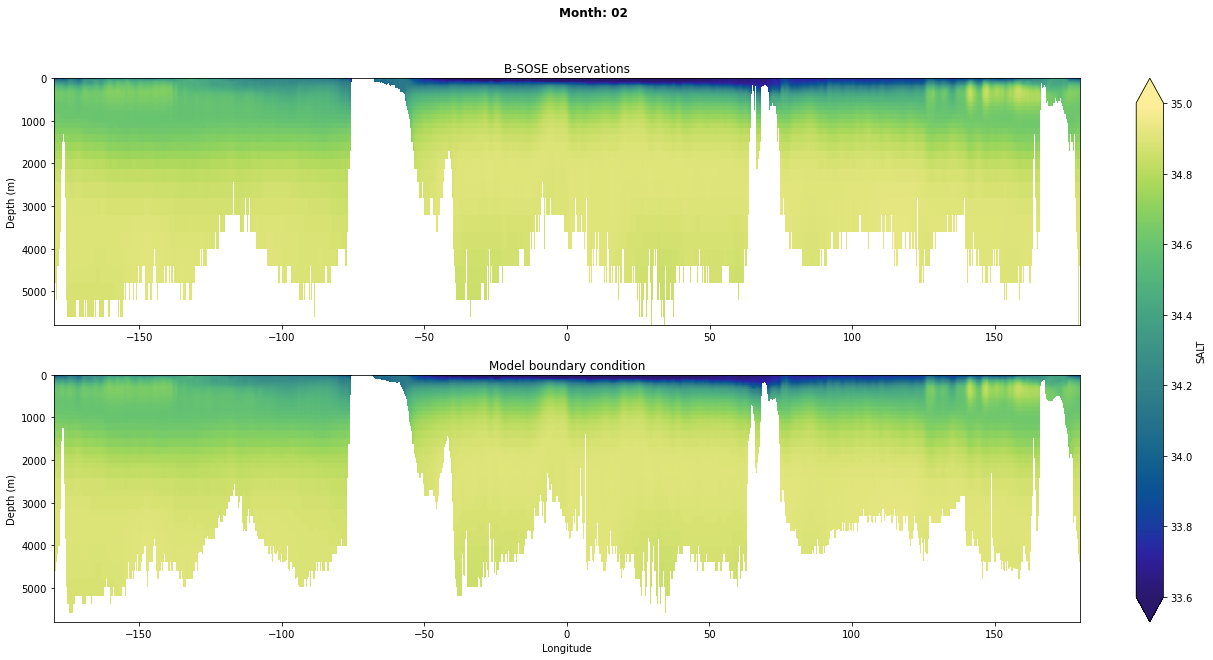

In [63]:
visualize_bdy(source_varp, bdy_cond, month, var, nemo_mask)

#### Check relative conservation of boundary conditions

In [90]:
# NEMO boundary condition:
bdy_cond_masked = xr.where(bdy_cond['SALT']==9999, np.nan, bdy_cond['SALT'])
nemo_cell_area  = nemo_mask.e1t.isel(y=-1)*nemo_mask.e2t.isel(y=-1) 
total_salt_nemo = nemo_cell_area*bdy_cond_masked*nemo_mask.e3t_0.isel(y=-1).rename({'nav_lev':'deptht'})

In [91]:
# SOSE content:
source_cell_area  = source_varp.rA
total_salt_source = source_cell_area*source_varp*source_varp.drF

In [92]:
print(f'Total salt content in boundary in NEMO: {np.nansum(total_salt_nemo.values):.2e}') 
print(f'Total salt content in boundary in source: {np.nansum(total_salt_source.values):.2e}')
#--> so, NEMO salt content is larger than in the original source dataset. That might just be because of a larger amount of open ocean area.

Total salt content in boundary in NEMO: 5.66e+16
Total salt content in boundary in source: 4.04e+16
